In [186]:
%matplotlib inline
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt


In [243]:
def deepdream(img_path,enhance_layer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # define model  enhance_layer番目の層までを抽出                                                                           
    model = models.vgg16(pretrained=True).features
    layers = list(model.children())
    model = nn.Sequential(*layers[:enhance_layer]).to(device).eval()
    for p in model.parameters():
        p.requires_grad_(False)
        
    #data->torchtensor
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512,512), interpolation=cv2.INTER_AREA)

    # transforms(724, 1024, 3)->torch.Size([1, 3, 512, 512])                                                                            
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    totensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=mean, std=std)
    transform = transforms.Compose([totensor, normalize])

    x_org = transform(img).unsqueeze(0)

    
    noct = 20
    niter = 200
    oct_scale =1.2
    lr = 0.001
    for ioct in range(noct):
#             print(ioct)

            #画像をリサイズ小さい画像から
            s = x_org.shape[2]//int(oct_scale**(noct-ioct-1))
            x_base = F.adaptive_avg_pool2d(x_org, s).to(device)

            if ioct == 0:
                x = x_base
            else:
                #画像のサイズが大きくなった時のエッジ保持
                x = x_base + F.interpolate(x, s, mode='bicubic', align_corners=False)

            x = x.detach().requires_grad_(True)
            for i in range(niter):
                y = model.forward(x)
                #lossは出力の二乗和
                loss = y.norm()
                #逆伝播
                loss.backward()
                #画像の勾配更新
                avg_grad = torch.abs(x.grad).mean().item()
                norm_lr = lr/avg_grad
                x.data += norm_lr * x.grad.detach() # 勾配と逆方向に移動                           
                for j in range(3):
                    upper = (1-mean[j])/std[j]
                    lower = -mean[j]/std[j]
                    #更新値修正
                    x.data[:,j] = torch.clamp(x.detach()[:,j], lower, upper)
                x.grad.detach().zero_()
                
            #画像のエッジ保持
            x.data -= x_base
            
    # 出力用の整形                                                                             
    x = (x+x_base).to('cpu')
    mean = mean.reshape(1,3,1,1).to('cpu')
    std = std.reshape(1,3,1,1).to('cpu')
    x = torch.clamp((x*std + mean)*255, 0, 255)#0~255に戻す
    x = x.detach().type(torch.uint8)
    x = x.squeeze().permute(1,2,0)
    return x

## 後半の層

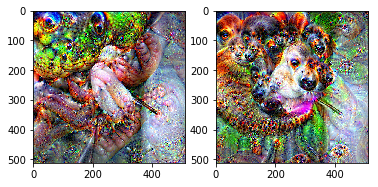

In [244]:
plt.subplot(1,2,1)
plt.imshow(deepdream('bird.jpg',28))
plt.subplot(1,2,2)
plt.imshow(deepdream('bird.jpg',24))

## 中間の層

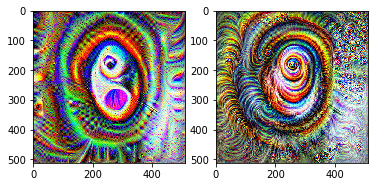

In [246]:
plt.subplot(1,2,1)
plt.imshow(deepdream('bird.jpg',15))
plt.subplot(1,2,2)
plt.imshow(deepdream('bird.jpg',20))

## 前半の層

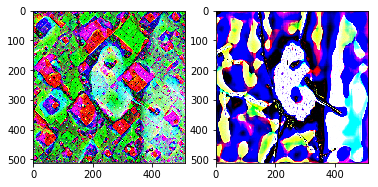

In [245]:
plt.subplot(1,2,1)
plt.imshow(deepdream('bird.jpg',10))
plt.subplot(1,2,2)
plt.imshow(deepdream('bird.jpg',2))

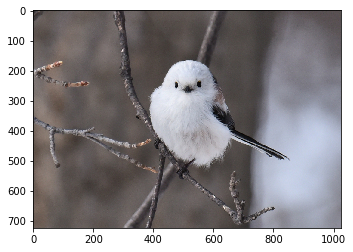

In [247]:
plt.imshow(cv2.cvtColor(cv2.imread('bird.jpg'), cv2.COLOR_BGR2RGB))

# 考察
中間レイヤー後半の層、中間の層、前半の層で分けてdeepdreamを行った。前半の層では画像のエッジと色のクラスタリングのようなものを行っていると考えられる。中間の層の左の画像では鳥の位置に鱗のようなものができており、少しづつ意味を持ち始めているのが分かる。鳥の原型はあまりとどめてはいないが鳥の位置が渦のようになっておりクラス分類に重要な意味を持っていることを示しているのだと考えられる。後半の層ではより意味を持ったものに変化していることが分かる。このことから後半の層にはよりクラス分類に重要な意味を持った情報があると考えられる。